In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from datetime import datetime, timedelta

## Load data and make compatible

In [2]:
# load Zambia shapefiles
zambia = 'Data/district.shp'

# read shapefile into geodataframe
gdf = gpd.read_file(zambia)

print(gdf.head())

ERROR 1: PROJ: proj_create_from_database: Open of /mnt/shared/moduleapps/EarthSci/Python-3.9.15-Mamba/share/proj failed


       GID_2 GID_0 COUNTRY    GID_1   NAME_1 NL_NAME_1        NAME_2  \
0  ZMB.1.1_2   ZMB  Zambia  ZMB.1_1  Central        NA      Chibombo   
1  ZMB.1.2_2   ZMB  Zambia  ZMB.1_1  Central        NA      Chisamba   
2  ZMB.1.3_2   ZMB  Zambia  ZMB.1_1  Central        NA      Chitambo   
3  ZMB.1.4_2   ZMB  Zambia  ZMB.1_1  Central        NA  Itezhi-tezhi   
4  ZMB.1.5_2   ZMB  Zambia  ZMB.1_1  Central        NA         Kabwe   

  VARNAME_2 NL_NAME_2    TYPE_2 ENGTYPE_2 CC_2 HASC_2  \
0        NA        NA  District  District   NA     NA   
1        NA        NA  District  District   NA     NA   
2        NA        NA  District  District   NA     NA   
3        NA        NA  District  District   NA     NA   
4        NA        NA  District  District   NA     NA   

                                            geometry  
0  POLYGON ((28.00409 -14.51361, 28.00989 -14.514...  
1  POLYGON ((28.36680 -15.16628, 28.36061 -15.162...  
2  POLYGON ((29.81841 -12.98202, 29.82574 -12.495...  
3  P

In [3]:
# load growing period data
growing_period_df = pd.read_csv('district_growing_periods.csv')
growing_period_df.head()

,district,year,mean_growing_period
0,Chibombo,2000,173.409091
1,Chisamba,2000,173.619048
2,Chitambo,2000,178.753521
3,Itezhi-tezhi,2000,161.838384
4,Kabwe,2000,174.444444


In [5]:
# merge spei and growing season dataframes
combined_df = pd.merge(spei_annual, growing_period_df, on=['district', 'year'], how='inner')

combined_df.to_csv('spei_mean_growing_season.csv')

In [4]:
# load csv with mean start dates
df = pd.read_csv('growing_season_district.csv')

# calcluate mean end date per year
df['mean_end_day'] = df['mean_start_day'] + df['mean_growing_period']

def day_to_date(row):
    try:
        return(datetime(int(row['year']), 1, 1,) + timedelta(days=int(row['mean_end_day']) - 1)).strftime('%B %d')
    except:
        return None

df['end_date'] = df.apply(day_to_date, axis = 1)

df.to_csv('full_grow_data.csv', index=False)

## Calculate mean and median SPEI per growing season, district, and year

In [11]:
grow_df = pd.read_csv('full_grow_data.csv')
spei_df = pd.read_csv('spei_long.csv')

grow_df['mean_start_date'] = grow_df.apply(
    lambda row: datetime(int(row['year']), 1, 1) + timedelta(days=row['mean_start_day'] - 1),
    axis=1
)

grow_df['mean_end_date'] = grow_df['mean_start_date'] + pd.to_timedelta(grow_df['mean_growing_period'], unit='D')

spei_df['date'] = pd.to_datetime(spei_df['date'])

# create empty list to store results
seasonal_spei = []

for _, row in grow_df.iterrows():
    district = row['district']
    start = row['mean_start_date']
    end = row['mean_end_date']
    season_year = row['year']
    # filter SPEI for this district and growing season
    mask = (
        (spei_df['district'] == district) &
        (spei_df['date'] >= start) &
        (spei_df['date'] <= end)
    )
    matched_spei = spei_df.loc[mask]
    # if matches found, compute mean SPEI
    if not matched_spei.empty:
        mean_spei = matched_spei['spei'].mean()
        median_spei = matched_spei['spei'].median()
        seasonal_spei.append({
            'district': district,
            'season_year': season_year,
            'mean_growing_spei': mean_spei,
            'median_growing_spei': median_spei,
            'n_months': matched_spei.shape[0]
        })

seasonal_df = pd.DataFrame(seasonal_spei)

In [13]:
seasonal_df.head()
seasonal_df.to_csv('spei_seasonal_avg.csv')

## Bin districts into provinces

In [3]:
# create district - province lookup
district_to_province = gdf[['NAME_2', 'NAME_1']].drop_duplicates()
district_to_province.columns = ['district', 'province']

# merge with SPEI/growing period data
growing_df = pd.read_csv('spei_seasonal_avg.csv')

# merge province info
merged = pd.merge(growing_df, district_to_province, on='district', how='left')

# inspect
merged.head()

#merged.to_csv('district_province_spei_growingperiod.csv')

,Unnamed: 0,district,season_year,mean_growing_spei,median_growing_spei,n_months,province
0,0,Chadiza,2000,0.838769,0.781813,6,Eastern
1,1,Chadiza,2001,0.353488,0.303945,6,Eastern
2,2,Chadiza,2002,0.281255,0.244052,6,Eastern
3,3,Chadiza,2003,0.227219,0.217295,5,Eastern
4,4,Chadiza,2004,0.025194,0.084612,6,Eastern


In [27]:
# combine with grow df to add column for mean_start_day
# load full grow csv
full_grow = pd.read_csv('full_grow_data.csv')

# merge in province info
full_grow = pd.merge(full_grow, district_to_province, on='district', how='left')

# compute average mean_start_day per province
province_avg_start = full_grow.groupby('province')['mean_start_day'].mean().reset_index()

# convert to calendar date
province_avg_start['avg_start_date'] = province_avg_start['mean_start_day'].apply(
    lambda d: (datetime(2001, 1, 1) + timedelta(days=d - 1)).strftime('%B %d')
)

# rename column
province_avg_start = province_avg_start.rename(columns={'avg_start_date': 'province_avg_start_date'})

# merge with new copy of dataframe
merged_new = pd.merge(merged, province_avg_start[['province', 'province_avg_start_date']], on='province', how='left')

# compute average mean_end_day per province
province_avg_end = full_grow.groupby('province')['mean_end_day'].mean().reset_index()

# convert to calendar date
province_avg_end['avg_end_date'] = province_avg_end['mean_end_day'].apply(
    lambda d: (datetime(2001, 1, 1) + timedelta(days=d - 1)).strftime('%B %d')
)

# rename column
province_avg_end = province_avg_end.rename(columns={'avg_end_date': 'province_avg_end_date'})

# merge
merged_new = pd.merge(merged_new, province_avg_end[['province', 'province_avg_end_date']], on='province', how='left')

# drop weird columns
merged_new = merged_new.drop(columns=['province_avg_start_date_x', 'province_avg_start_date_y'], errors='ignore')

merged_new.head()

,Unnamed: 0,district,season_year,mean_growing_spei,median_growing_spei,n_months,province,province_avg_start_date,province_avg_end_date
0,0,Chadiza,2000,0.838769,0.781813,6,Eastern,November 26,May 04
1,1,Chadiza,2001,0.353488,0.303945,6,Eastern,November 26,May 04
2,2,Chadiza,2002,0.281255,0.244052,6,Eastern,November 26,May 04
3,3,Chadiza,2003,0.227219,0.217295,5,Eastern,November 26,May 04
4,4,Chadiza,2004,0.025194,0.084612,6,Eastern,November 26,May 04


In [47]:
merged_new.to_csv('district_province_spei_stats.csv')

In [28]:
# group by province and season to calculate province-level SPEI metrics
province_summary = merged_new.groupby(['province', 'season_year']).agg(
    mean_spei = ('mean_growing_spei', 'mean'),
    median_spei = ('median_growing_spei', 'median'),
    n_districts = ('district', 'nunique'),
    province_avg_start_date=('province_avg_start_date', 'first'),
    province_avg_end_date=('province_avg_end_date', 'first')
).reset_index()

# examine
province_summary.head()

,province,season_year,mean_spei,median_spei,n_districts,province_avg_start_date,province_avg_end_date
0,Central,2000,1.112741,1.053000,11,November 18,April 22
1,Central,2001,0.877591,0.830469,11,November 18,April 22
2,Central,2002,0.683877,0.559107,11,November 18,April 22
3,Central,2003,0.937202,1.048594,11,November 18,April 22
4,Central,2004,0.247644,0.496656,11,November 18,April 22


In [34]:
province_summary.to_csv('province_summary.csv')

In [35]:
df = pd.read_csv('province_summary.csv')

## Visualize data

### Mean

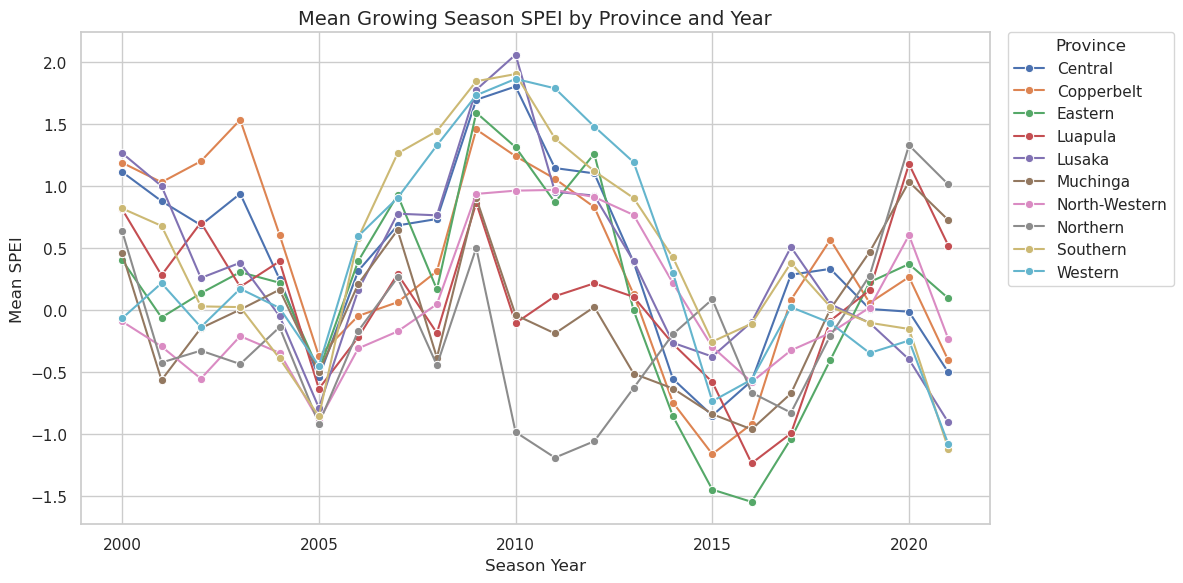

In [29]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=province_summary,
    x='season_year',
    y='mean_spei',
    hue='province',
    marker='o'
)

plt.title('Mean Growing Season SPEI by Province and Year', fontsize=14)
plt.xlabel('Season Year')
plt.ylabel('Mean SPEI')
plt.legend(title='Province', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

### Median

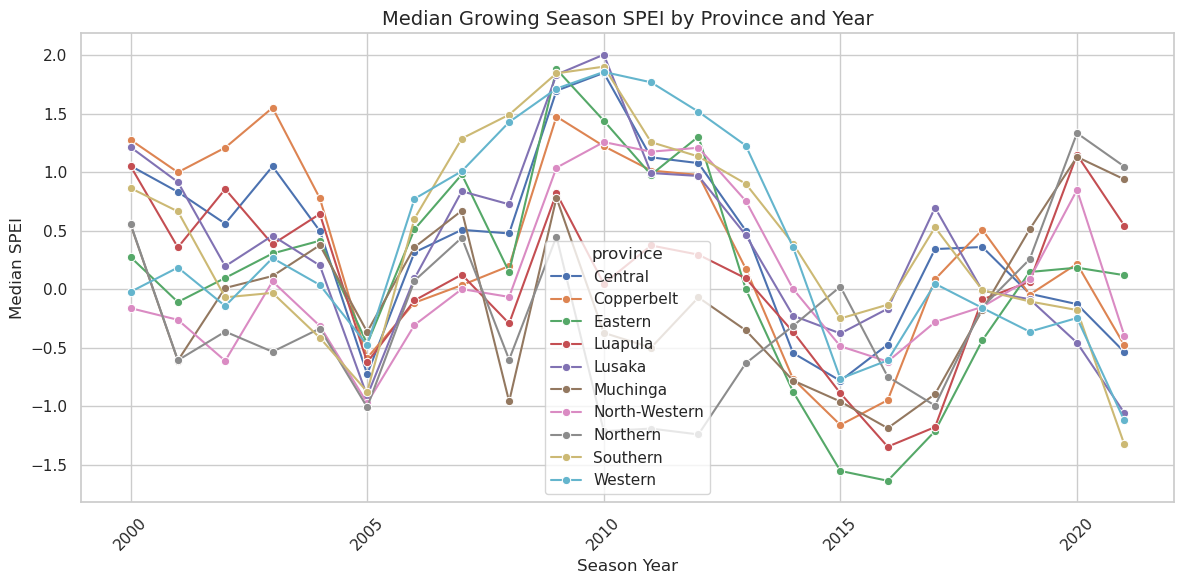

In [38]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=province_summary,
    x='season_year',
    y='median_spei',
    hue='province',
    marker='o'
)

plt.title('Median Growing Season SPEI by Province and Year', fontsize=14)
plt.xlabel('Season Year')
plt.ylabel('Median SPEI')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Correlate with forest loss

### 1-year lag for mean district-level SPEI

In [13]:
spei_df = pd.read_csv('district_province_spei_stats.csv')
# rename season_year column for compatability with forest loss
spei_df = spei_df.rename(columns={'season_year': 'year', 'mean_growing_spei': 'mean_spei', 'median_growing_spei': 'median_spei'})
# lag SPEI forward for correlation
spei_df['year'] += 1

In [14]:
# load forest loss data
forest_df = pd.read_csv('district_forest_cover.csv')
forest_df['year'] = forest_df['year'].astype(int)

# merge in province info
forest_df = pd.merge(forest_df, district_to_province, on='district', how='left')

In [15]:
# merge 
combined = pd.merge(
    forest_df, 
    spei_df[['district', 'year', 'mean_spei', 'median_spei']],
    on=['district', 'year'],
    how='left'
)

# investigate
combined.head()

,district,year,forest_cover_ha,loss_m2,percent_loss_annual,province,mean_spei,median_spei
0,Chadiza,2001,57181.013721,5.136993e+05,0.089757,Eastern,0.838769,0.781813
1,Chadiza,2002,57127.207503,5.380622e+05,0.094098,Eastern,0.353488,0.303945
2,Chadiza,2003,56960.977318,1.662302e+06,0.290983,Eastern,0.281255,0.244052
3,Chadiza,2004,56773.795452,1.871819e+06,0.328614,Eastern,0.227219,0.217295
4,Chadiza,2005,56703.324923,7.047053e+05,0.124125,Eastern,0.025194,0.084612


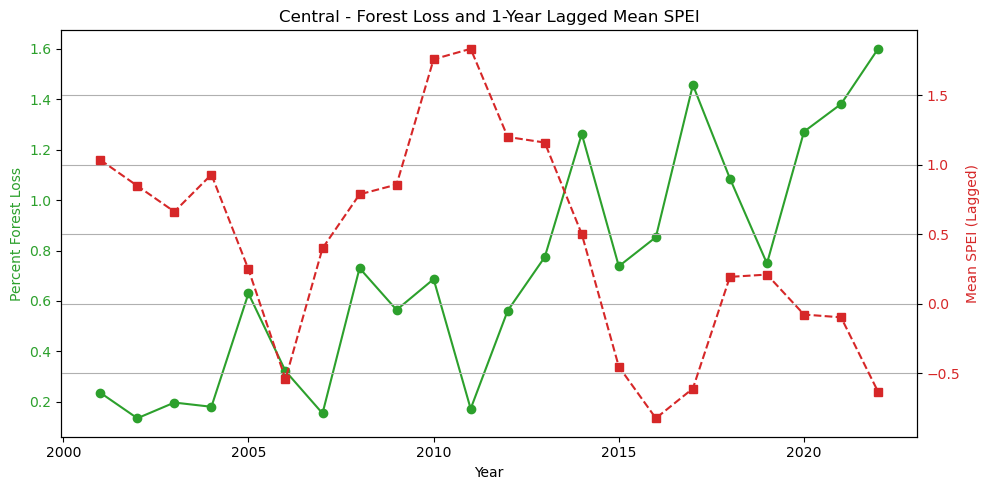

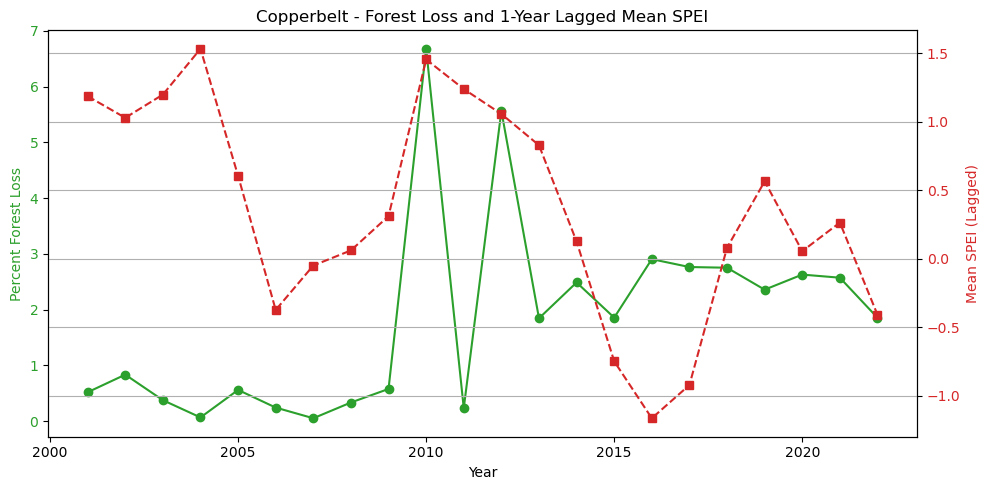

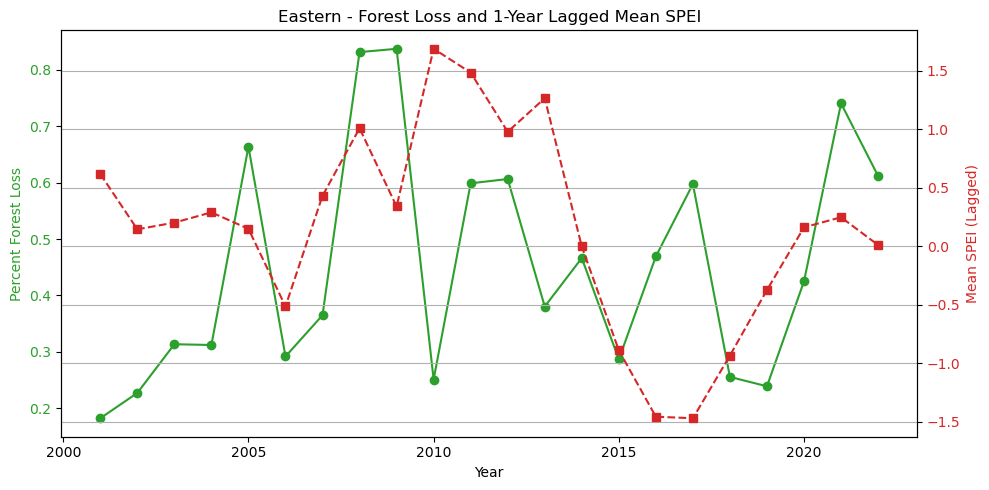

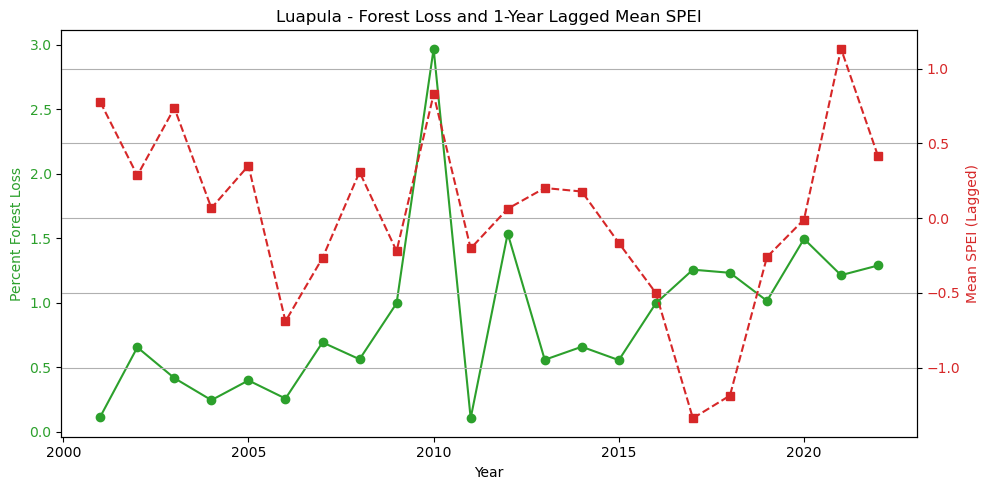

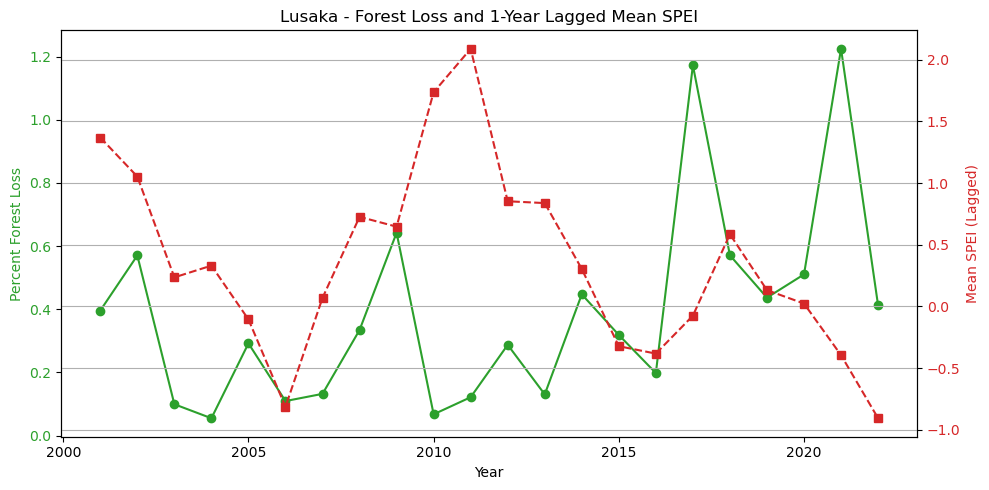

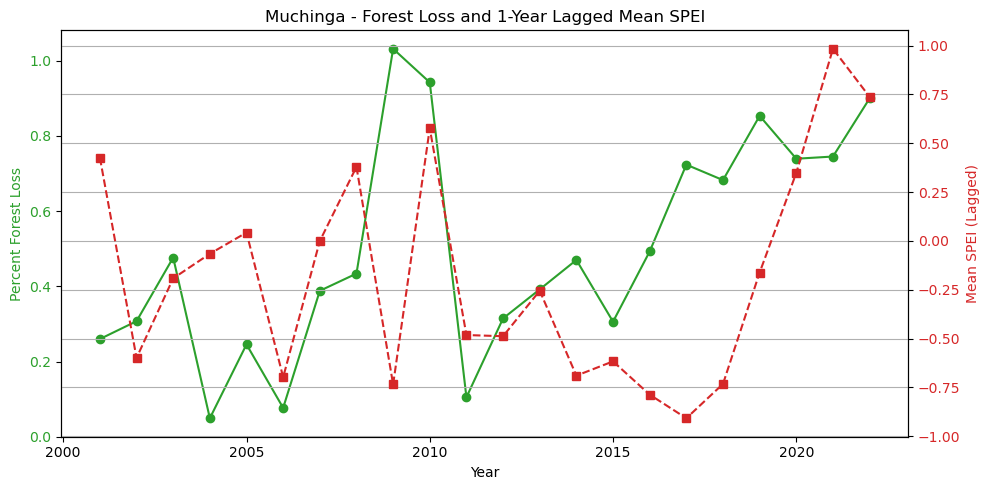

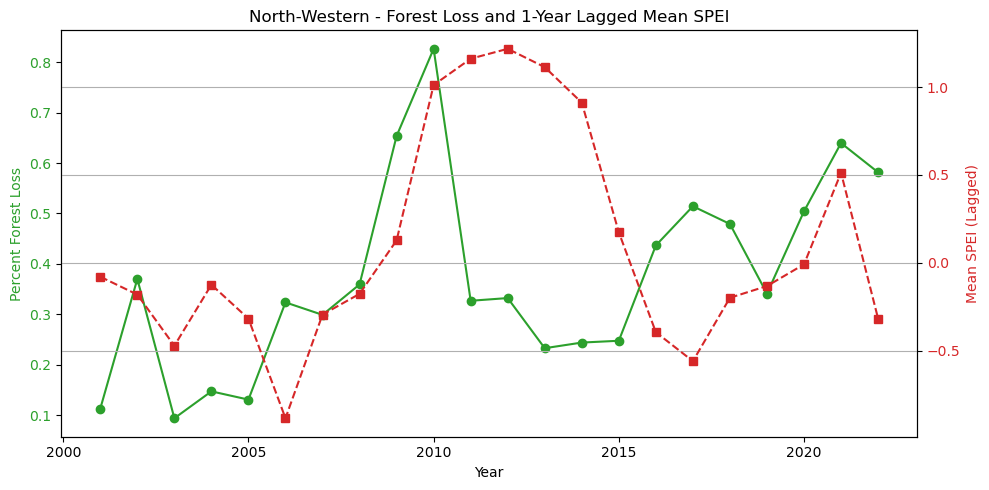

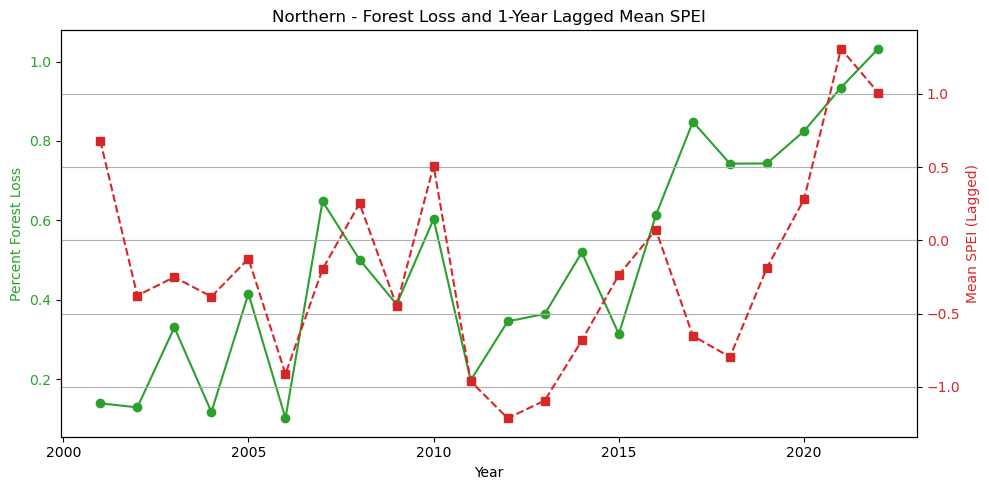

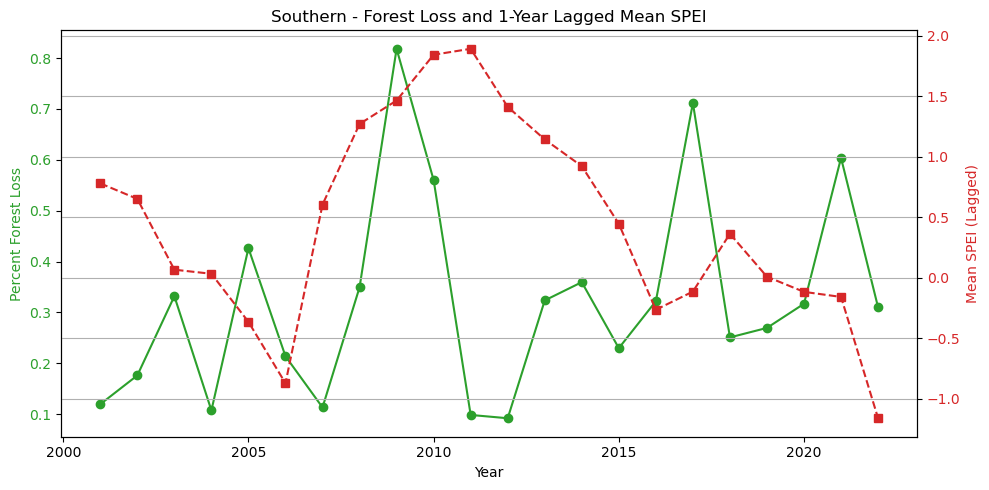

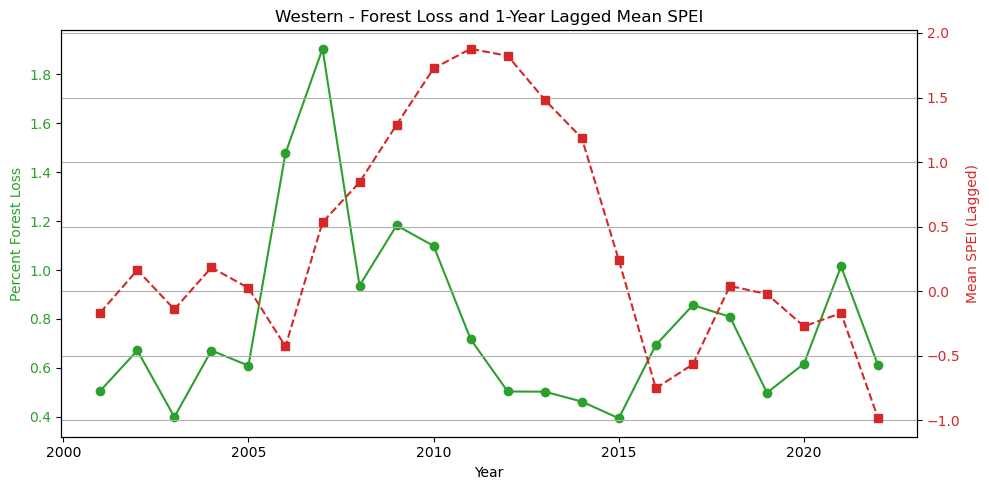

In [24]:
# ensure 'year' column is in numeric format and sorted
combined['year'] = combined['year'].astype(int)
combined = combined.sort_values(['province', 'year'])

# loop through each province
province_year_avg = combined.groupby(['province', 'year'], as_index=False).agg({
    'percent_loss_annual': 'mean',
    'mean_spei': 'mean'
})


for province in province_year_avg['province'].dropna().unique():
    df = province_year_avg[province_year_avg['province'] == province]
    fig, ax1 = plt.subplots(figsize=(10, 5))
    # plot forest loss on left y-axis
    ax1.plot(df['year'], df['percent_loss_annual'], color = 'tab:green', label = 'Forest Loss (%)', marker='o')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Percent Forest Loss', color='tab:green')
    ax1.tick_params(axis='y', labelcolor='tab:green')
    # plot SPEI on right y-axis
    ax2 = ax1.twinx()
    ax2.plot(df['year'], df['mean_spei'], color='tab:red', label='Lagged SPEI', linestyle='--', marker='s')
    ax2.set_ylabel('Mean SPEI (Lagged)', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    # set title and legend
    plt.title(f'{province} - Forest Loss and 1-Year Lagged Mean SPEI')
    fig.tight_layout()
    plt.grid(True)
    plt.show()

### 1-year lag for median district-level SPEI

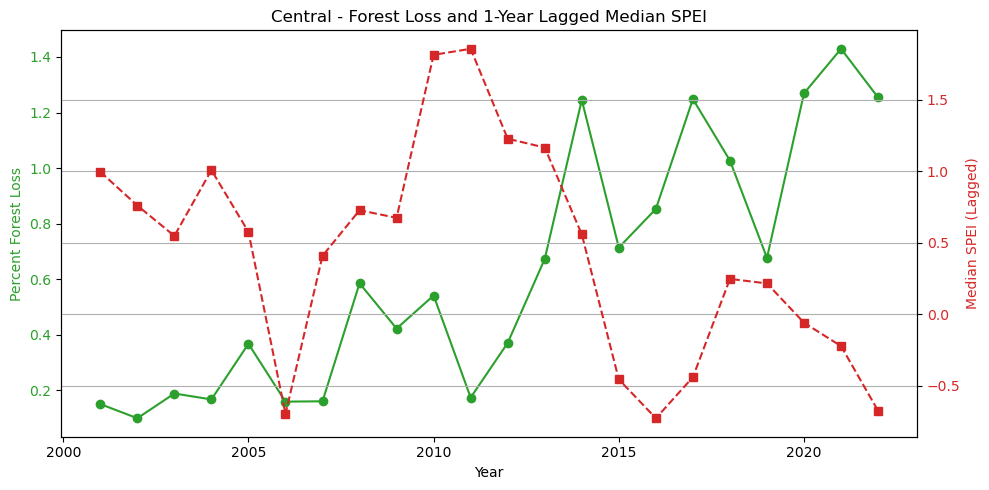

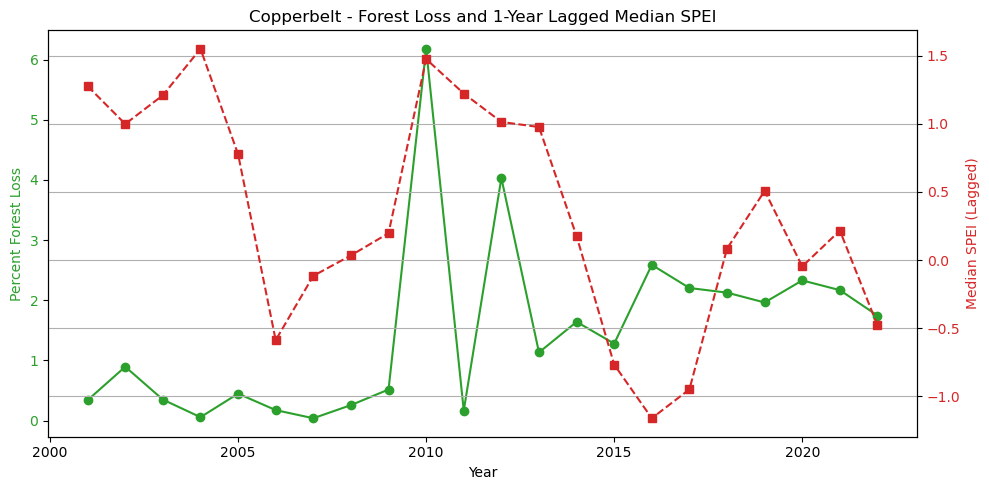

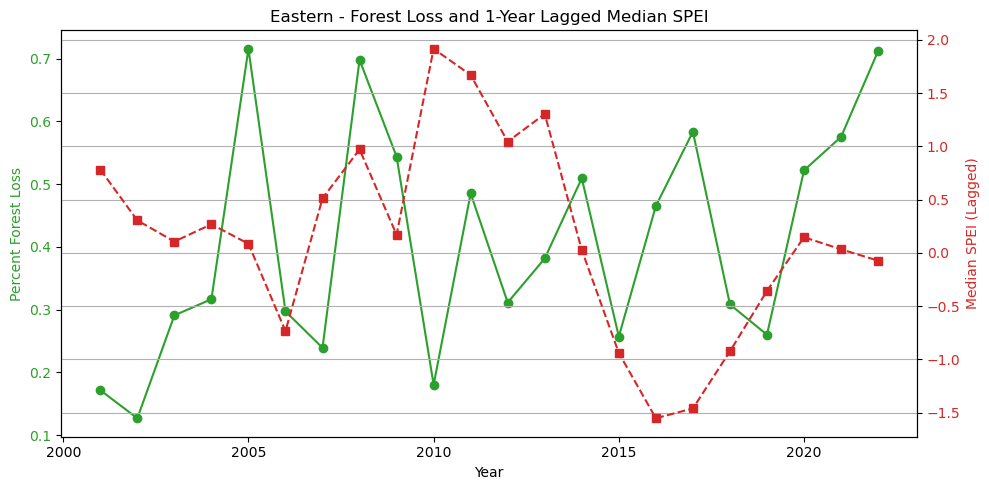

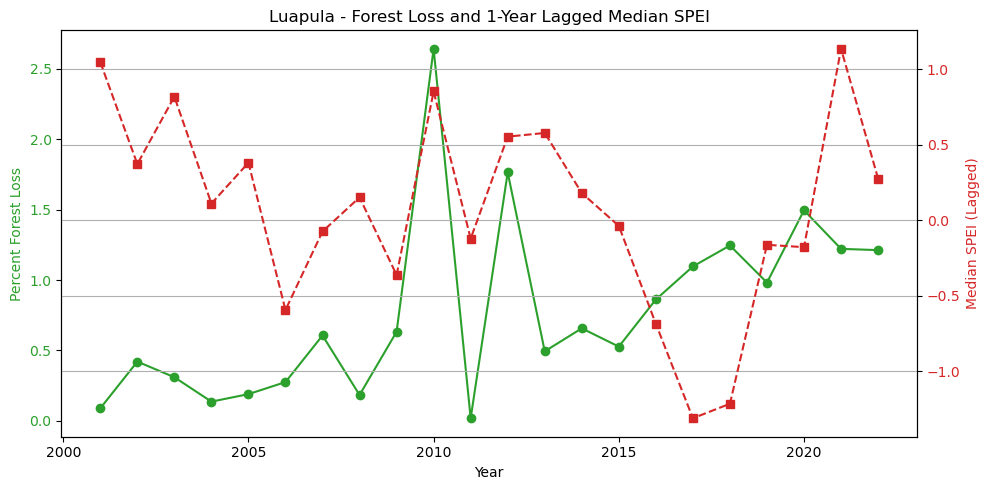

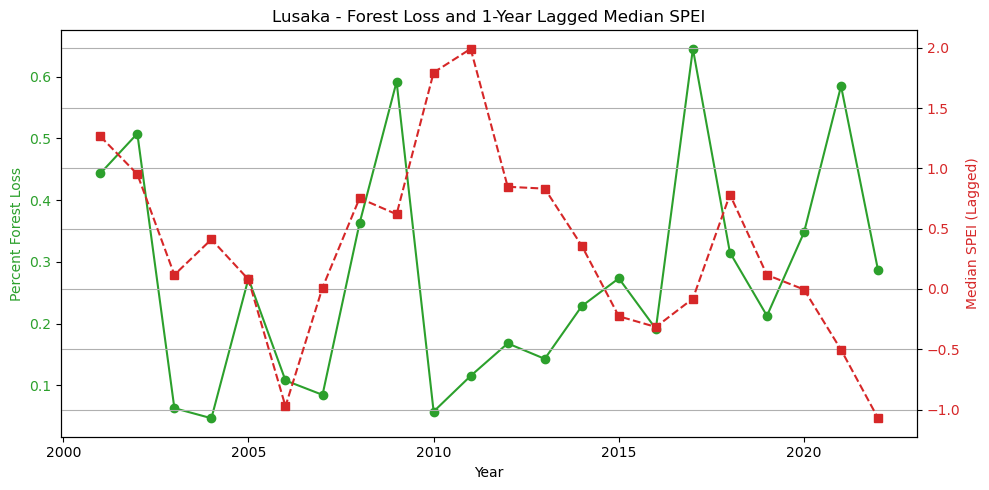

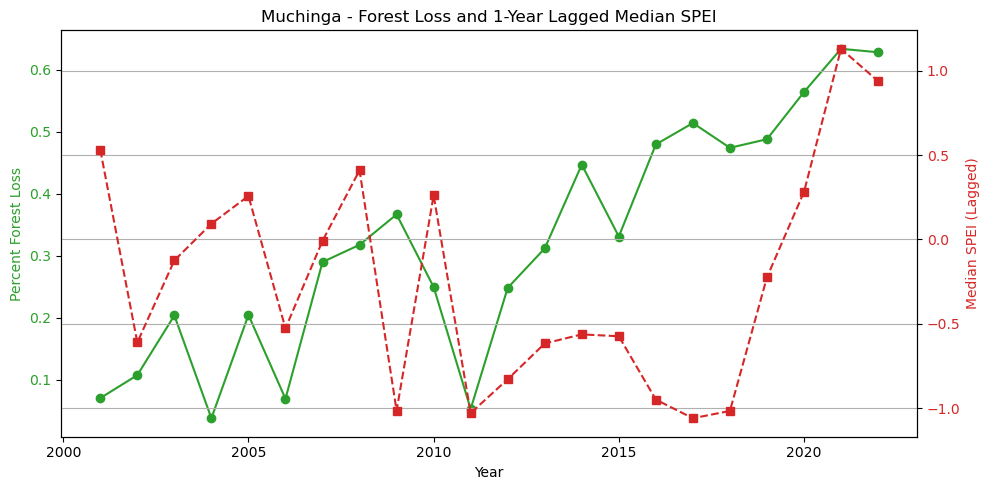

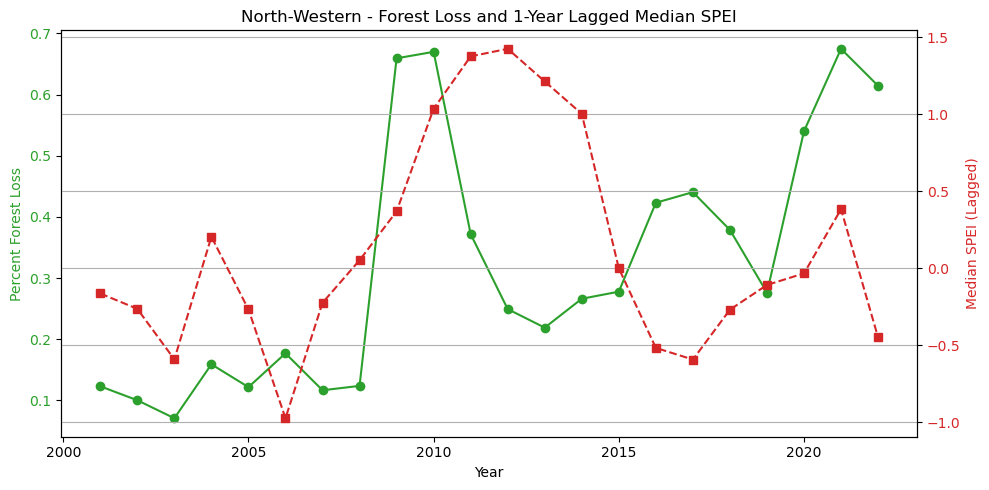

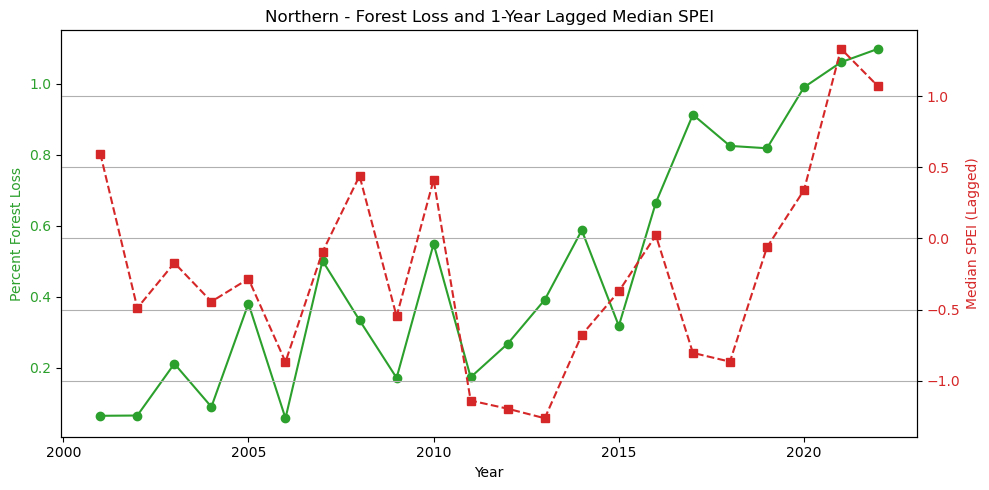

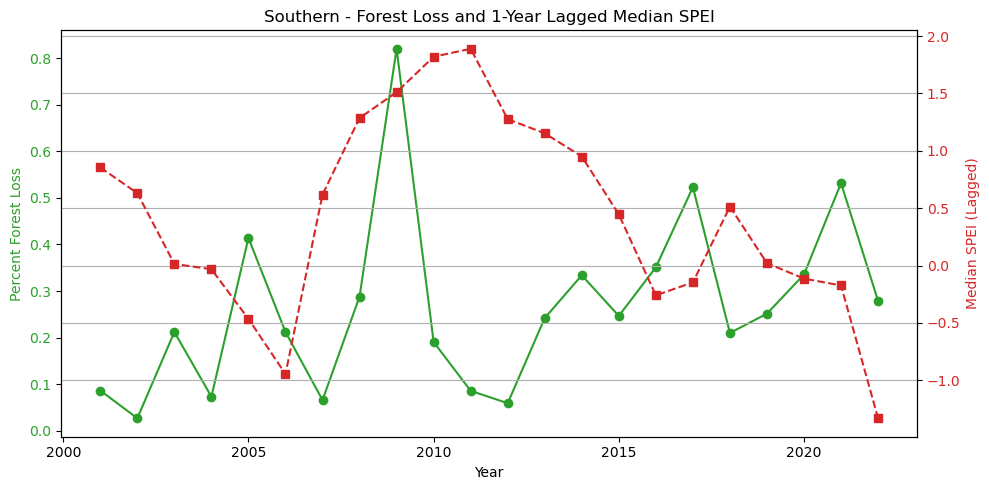

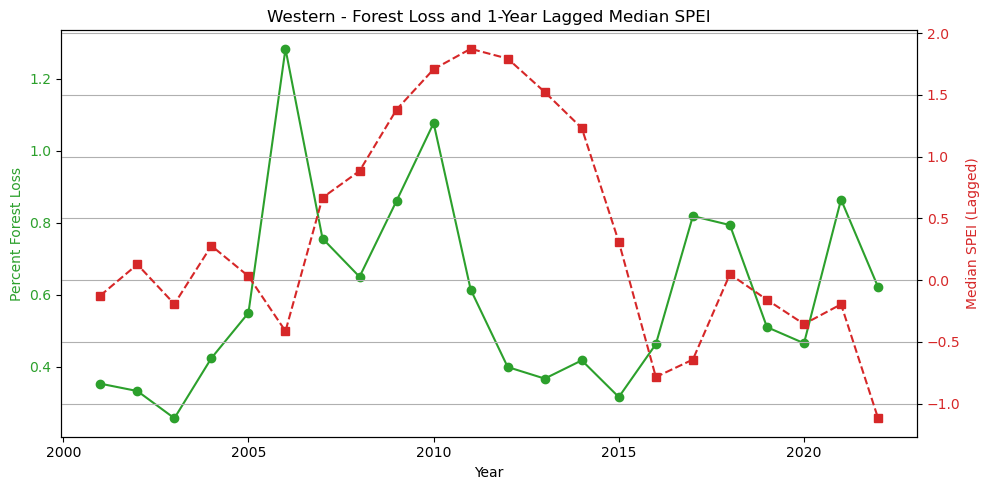

In [23]:
# loop through each province
province_year_avg = combined.groupby(['province', 'year'], as_index=False).agg({
    'percent_loss_annual': 'median',
    'median_spei': 'median'
})


for province in province_year_avg['province'].dropna().unique():
    df = province_year_avg[province_year_avg['province'] == province]
    fig, ax1 = plt.subplots(figsize=(10, 5))
    # plot forest loss on left y-axis
    ax1.plot(df['year'], df['percent_loss_annual'], color = 'tab:green', label = 'Forest Loss (%)', marker='o')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Percent Forest Loss', color='tab:green')
    ax1.tick_params(axis='y', labelcolor='tab:green')
    # plot SPEI on right y-axis
    ax2 = ax1.twinx()
    ax2.plot(df['year'], df['median_spei'], color='tab:red', label='Lagged SPEI', linestyle='--', marker='s')
    ax2.set_ylabel('Median SPEI (Lagged)', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    # set title and legend
    plt.title(f'{province} - Forest Loss and 1-Year Lagged Median SPEI')
    fig.tight_layout()
    plt.grid(True)
    plt.show()

## Code graveyard

In [ ]:
# loop through provinces
for province in df['province'].dropna().unique():
    province_df = df[df['province'] == province]
    # group by year
    grouped = province_df.groupby('year')[['mean_growing_period', 'spei']].mean().reset_index()
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.scatter(grouped['year'], grouped['mean_growing_period'], color='teal', marker='o', label='Growing Period')
    ax1.set_ylabel('Mean Growing Period (days)', color='teal')
    ax1.tick_params(axis='y', color='teal')
    # create separate y-axis for SPEI
    ax2 = ax1.twinx()
    ax2.scatter(grouped['year'], grouped['spei'], color='red', marker='o', label='SPEI')
    ax2.set_ylabel('SPEI', color='red')
    ax2.tick_params(axis='y', color='red')

    plt.title(f'SPEI and Growing Period - {province} Province')
    ax1.set_xlabel('Year')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# aggregate SPEI to annual mean
#spei_annual = spei_long.groupby(['district', 'year'])['spei'].mean().reset_index()

# export to csv
#spei_annual.to_csv('district_spei_annual.csv', index=False)

In [ ]:
# load district-level SPEI data
spei_df = pd.read_csv('district_spei_average.csv')

# remove spatial_ref column
spei_df_clean = spei_df.drop(columns='spatial_ref')

# convert to long format
spei_long = spei_df_clean.melt(
    id_vars = 'date',
    var_name = 'district',
    value_name = 'spei'
)

# convert to datetime and extract year
spei_long['date'] = pd.to_datetime(spei_long['date'])
spei_long['year'] = spei_long['date'].dt.year

# export to csv
spei_long.to_csv('spei_long.csv', index=False)

In [ ]:
# loop through each province
for province in df['province'].dropna().unique():
    province_df = df[df['province'] == province]

    # faceted by year
    # linear regression line
    g = sns.lmplot(
        data=province_df,
        x='spei',
        y='mean_growing_period',
        col='year',
        col_wrap=4, 
        height=4,
        scatter_kws={'alpha': 0.5},
        line_kws={'color': 'red'},
        ci=None
    )

    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Mean Growing Period vs. SPEI — {province} Province', fontsize=16)
    plt.show()

In [ ]:
# loop through each province
for province in df['province'].dropna().unique():
    province_df = df[df['province'] == province]

    # faceted by year
    # colored by district
    g = sns.lmplot(
        data=province_df,
        x='spei',
        y='mean_growing_period',
        col='year',
        hue='district',
        col_wrap=4, 
        height=4,
        scatter_kws={'alpha': 0.5},
        #line_kws={'color': 'red'},
        ci=None
    )

    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Mean Growing Period vs. SPEI — {province} Province', fontsize=16)
    plt.show()